## TO-DO
- Evaluation (metrics) -> plot of training vs epoch for all, AUC
- Ablation study: CV comparing binary vs no binary for MTL

Training/implementation methodologies: Need to be more scientific in how we chose
- Hyper parameters e.g LR (LR finder), batch_size (quote frozen batch norm)
- CV for ablation, fine-tuning, 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [2]:
# Set configs
batch_size = 8
batch_size_val = 8
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [3]:
print(num_train, num_val, num_test)

2210 738 738


In [4]:
# This is currently for CV only
# Load our data pipeline
# CrossVal: 0 = no CV, 1 = training set, 2 = val set
loader1 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=1, CV_iteration=0)
loader2 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=2, CV_iteration=0)

# Train set
img_ds = loader1.get_image_ds().repeat()
masks_ds = loader1.get_mask_ds().repeat()
label_ds = loader1.get_binary_ds().repeat()
bbox_ds = loader1.get_bboxes_ds().repeat()

# Validation set
img_ds_val = loader2.get_image_ds().repeat()
masks_ds_val = loader2.get_mask_ds().repeat()
label_ds_val = loader2.get_binary_ds().repeat()
bbox_ds_val = loader2.get_bboxes_ds().repeat()

### Plot some examples (Ignore if training)

In [4]:
# Make some examples
examples = tf.data.Dataset.zip((img_ds, masks_ds, bbox_ds)).as_numpy_iterator()
display_list = next(examples)

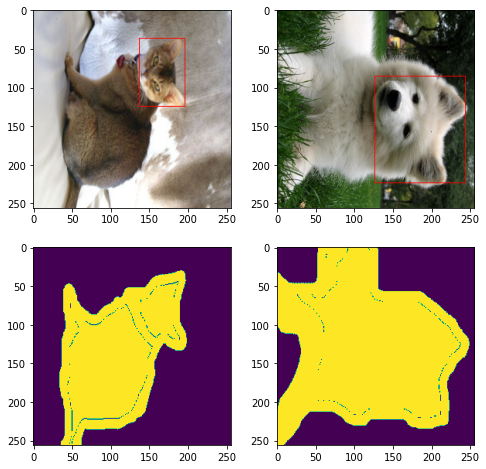

In [7]:
# View some examples with augmentation
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8,8))
display_list = tools.data_augmentation(display_list[0], display_list[1], display_list[2])
for i in range(2):
    box_img = tf.image.draw_bounding_boxes(tf.expand_dims(display_list[0][i,...], 0), tools.fix_bbox(display_list[2][i]).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    ax1[i].imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax2[i].imshow((display_list[1][i,...]))

### Build our MTL(not needed for cv, need to rebuild model for each cv)

In [ ]:
### CLEARS OLD MODELS IN CACHE
tf.keras.backend.clear_session()

In [5]:
# Get encoder
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=True)

In [ ]:
encoder.summary()

In [6]:
# Use our MTL framework to custom build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=True)
mtl_builder.add_bbox_classification_head(base_model_name, trainable=True)
model = mtl_builder.build_mtl_model()

In [ ]:
model.summary()

### Train model

In [5]:
def generator_img():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        # Regularisation and shuffling
        X, Y1, Y2, Y3 = tools.get_randomised_data([X, Y1, Y2, Y3])
        # X, Y1, Y3 = tools.data_augmentation(X, Y1, Y3) # Fix augmentation
        
        yield X, (Y1, Y2, Y3)

In [6]:
def generator_img_val():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        yield X, (Y1, Y2, Y3)

In [9]:
# model.compile(optimizer=keras.optimizers.Adam(1e-4),
#               loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                     'bin_class_out' : tf.keras.losses.BinaryCrossentropy(),
#                     'bbox_out' : tf.keras.losses.MeanAbsoluteError()},
#               loss_weights=[1,1,1/100], # Scale MAE to BC range
#               metrics=['accuracy'])

In [7]:
for cv_iter in range(3):
      print(f"-------------------- start cross val {cv_iter+1} --------------------")
      # This is currently for CV only
      # Load our data pipeline
      # CrossVal: 0 = no CV, 1 = training set, 2 = val set
      loader1 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=1, CV_iteration = cv_iter)
      loader2 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=2, CV_iteration = cv_iter)

      # Train set
      img_ds = loader1.get_image_ds().repeat()
      masks_ds = loader1.get_mask_ds().repeat()
      label_ds = loader1.get_binary_ds().repeat()
      bbox_ds = loader1.get_bboxes_ds().repeat()

      # Validation set
      img_ds_val = loader2.get_image_ds().repeat()
      masks_ds_val = loader2.get_mask_ds().repeat()
      label_ds_val = loader2.get_binary_ds().repeat()
      bbox_ds_val = loader2.get_bboxes_ds().repeat()

      ### CLEARS OLD MODELS IN CACHE
      tf.keras.backend.clear_session()

      # Get encoder
      base_model_name = 'B0'
      encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=True)

      # Use our MTL framework to custom build a model
      mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
      mtl_builder.add_segmentation_head()
      mtl_builder.add_binary_classification_head(base_model_name, trainable=True)
      mtl_builder.add_bbox_classification_head(base_model_name, trainable=True)
      model = mtl_builder.build_mtl_model()

      model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        'bin_class_out' : tf.keras.losses.BinaryCrossentropy(),
                        'bbox_out' : tf.keras.losses.MeanAbsoluteError()},
                  loss_weights=[1,1,1/100], # Scale MAE to BC range
                  metrics=['accuracy'])

      history = model.fit(generator_img(), validation_data=generator_img_val(), epochs=4, steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

      print("\n")

-------------------- start cross val 1 --------------------
Epoch 1/4
276/276 [==============================] - 144s 475ms/step - loss: 2.1627 - segnet_out_loss: 0.4336 - bin_class_out_loss: 0.6138 - bbox_out_loss: 111.5309 - segnet_out_accuracy: 0.7925 - bin_class_out_accuracy: 0.7246 - bbox_out_accuracy: 0.3016 - val_loss: 2.3426 - val_segnet_out_loss: 0.2808 - val_bin_class_out_loss: 0.9532 - val_bbox_out_loss: 110.8547 - val_segnet_out_accuracy: 0.8854 - val_bin_class_out_accuracy: 0.0380 - val_bbox_out_accuracy: 0.4334
Epoch 2/4
276/276 [==============================] - 131s 477ms/step - loss: 1.5068 - segnet_out_loss: 0.2136 - bin_class_out_loss: 0.2108 - bbox_out_loss: 108.2417 - segnet_out_accuracy: 0.9226 - bin_class_out_accuracy: 0.9185 - bbox_out_accuracy: 0.4810 - val_loss: 3.4308 - val_segnet_out_loss: 0.2354 - val_bin_class_out_loss: 2.1376 - val_bbox_out_loss: 105.7841 - val_segnet_out_accuracy: 0.8958 - val_bin_class_out_accuracy: 0.0000e+00 - val_bbox_out_accuracy: 0

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(list(range(10)), history.history['segnet_out_accuracy'], 'r-', label='Segmentation - Training Accuracy')
ax.plot(list(range(10)), history.history['val_segnet_out_accuracy'], 'r--', label='Segmentation - Validation Accuracy')
#ax.plot(list(range(10)), history.history['bin_class_out_accuracy'], 'c-', label='Classification - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bin_class_out_accuracy'], 'c--', label='Classification - Validation Accuracy')
ax2 = ax.twinx()
#ax.plot(list(range(10)), history.history['bbox_out_accuracy'], 'm-', label='Bounding Box - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bbox_out_accuracy'], 'm--', label='Bounding Box - Validation Accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Segmentation/Classification Accuracy')
ax2.set_ylabel('Bounding Box Accuracy')

In [ ]:
model.save('EffishingNetN')

## Test on test-set

In [39]:
model = tf.keras.models.load_model('EffishingNetN')

In [6]:
# Load test-set
img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)
label_ds_test = loader.get_binary_ds(test_mode=True)
bbox_ds_test = loader.get_bboxes_ds(test_mode=True)

In [ ]:
# Predict on test-set
seg_pred, bin_pred, bbox_pred = model.predict(img_ds_test, batch_size=10)
seg_pred = tf.where(seg_pred >= 0, 1, 0) # Convert to {0,1} binary classes
bin_pred = np.round(bin_pred) # Round confidence score

bin_acc = np.sum(bin_pred == label_ds_test)/label_ds_test.shape[0]
seg_acc = np.sum(seg_pred == masks_ds_test)/(masks_ds_test.shape[0]*(img_height*img_width))
iou = np.mean(tools.calculate_iou(bbox_ds_test, bbox_pred))
print(f'Binary Acc: {round(bin_acc*100, 3)}%,   Seg Acc: {round(seg_acc*100, 3)}%,    BBox IOU: {round(iou*100, 3)}%')

In [58]:
def show_seg_pred(img: np.array, mask_truth: np.array, mask_pred: np.array, bbox_truth: np.array, bbox_pred: np.array):
    ''' Show segmentation prediction with bounding box pred '''
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,12))
    seg_max = tf.where(mask_pred > 0, 1, 0)
    box_img_truth = tf.image.draw_bounding_boxes(tf.cast(tf.expand_dims(img, 0), tf.float32), tools.fix_bbox(bbox_truth).reshape([1,1,4])/256, np.array([[255, 0, 0]]))
    box_img = tf.image.draw_bounding_boxes(tf.cast(tf.expand_dims(img, 0), tf.float32), tools.fix_bbox(bbox_pred).reshape([1,1,4])/256, np.array([[0, 255, 0]]))
    
    ax1.imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img_truth)))
    ax2.imshow(tf.keras.utils.array_to_img(tf.squeeze(box_img)))
    ax3.imshow(tf.keras.utils.array_to_img(mask_truth))
    ax4.imshow(tf.keras.utils.array_to_img(seg_max[0]))
    ax1.set_title('Truth')
    ax2.set_title('Prediction')
    ax3.set_title('Truth')
    ax4.set_title('Prediction')

In [ ]:
# Visualise predictions
idx = list(range(img_ds_test.shape[0]))
random.shuffle(idx)
for i in range(3):
    show_seg_pred(img_ds_test[idx[i]], masks_ds_test[idx[i]], seg_pred[idx[i]][tf.newaxis, ...], bbox_ds_test[idx[i]], bbox_pred[idx[i]])